In [1]:
#User input to get variables to graph
#Multiple variables can be entered to plot simultaneously
def getVar():
    return input("Enter variable (enter 'end' to graph): ").lower()

In [2]:
#import pandas for dataframes, import seaborn for graphs, import csv, import os for file handling
%matplotlib notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import numpy as np
import time

sns.set_theme(style="darkgrid")

global df
csv_name = 'pipeline_outputs_SAY_10-15-2021.csv' #INPUT csv name here
df = pd.read_csv(csv_name) #import csv

list_outliers = {} #global list of outliers for later use


study_name = "SAY" #INPUT study name
date = "10/15/2021" #INPUT date updated (mm/dd/yyyy)

C:\Users\Nishant Bhamidipati\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. D

In [3]:
#drop unneeded columns 
for col in df.columns:
    if (('GlobalEfficiency' in col) or ('MaximizedModularity' in col) 
        or ('MeanClusteringCoeff' in col) or ('MeanTotalStrength'in col)
        or ('NetworkCharacteristic' in col) or ('TotalStrength' in col)
        or ('dummyrest' in col) or ('session_id' in col) or ('subject_id' in col)
        or ('dummy_rest' in col) or ('file_name' in col) or ('1back' in col)
        or ('acq_id' in col) or ('anatomical_zstat1' in col)):
        del df[col]

#filter id columns to include only integers
for id in df['id0'].dropna():
    if(len(id)>3):
        idnum=id[-3:]
        df['id0']=df['id0'].replace(id,idnum) 

In [4]:
#3D Graph Generation
def create3DGraph(col, r_value1, r_value2, mlr1, mlr2):
    try:
        #Male
        min1 = df_temp_Male['Age'].min()
        min2 = df_temp_Male['BMI'].min()
        max1 = df_temp_Male['Age'].max()
        max2 = df_temp_Male['BMI'].max()
        
        fig = plt.figure()
        fig.set_size_inches(12, 6)
        ax = fig.add_subplot(121,projection='3d')
        ax.scatter(df_temp_Male['Age'],df_temp_Male['BMI'],df_temp_Male[col],color = 'blue')
        ax.set_title(col + ": Male (R^2 = "+str(round(r_value1,5))+")")
        ax.set_xlabel("Age")
        ax.set_ylabel("BMI")
        ax.set_zlabel(col)
        
        #graph MLR (3D Regression)
        line1 = np.linspace(min1, max1, 30)   # range of porosity values
        line2 = np.linspace(min2, max2, 30)  # range of brittleness values
        xx_pred, yy_pred = np.meshgrid(line1, line2)
        model = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
        predicted = mlr1.predict(model)
        ax.plot_trisurf(xx_pred.flatten(), yy_pred.flatten(), predicted, color=(0,0,0,.3), edgecolor=(0,0,0,.2))
        
        #Female
        min1 = df_temp_Female['Age'].min()
        min2 = df_temp_Female['BMI'].min()
        max1 = df_temp_Female['Age'].max()
        max2 = df_temp_Female['BMI'].max()
        
        ax = fig.add_subplot(122,projection='3d')
        ax.scatter(df_temp_Female['Age'],df_temp_Female['BMI'],df_temp_Female[col],color = 'red')
        ax.set_title(col + ": Female (R^2 = "+str(round(r_value2,5))+")")
        ax.set_xlabel("Age")
        ax.set_ylabel("BMI")
        ax.set_zlabel(col)

        #graph MLR (3D Regression)
        line1 = np.linspace(min1, max1, 30)   # range of porosity values
        line2 = np.linspace(min2, max2, 30)  # range of brittleness values
        xx_pred, yy_pred = np.meshgrid(line1, line2)
        model = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
        predicted2 = mlr2.predict(model)
        ax.plot_trisurf(xx_pred.flatten(), yy_pred.flatten(), predicted2, color=(0,0,0,.3), edgecolor=(0,0,0,.2))
        
        plt.show(fig)
 
    except ValueError:
        print(col)
    except TypeError:
        print(col+" TypeError")

Enter variable (enter 'end' to graph): cjv


<IPython.core.display.Javascript object>


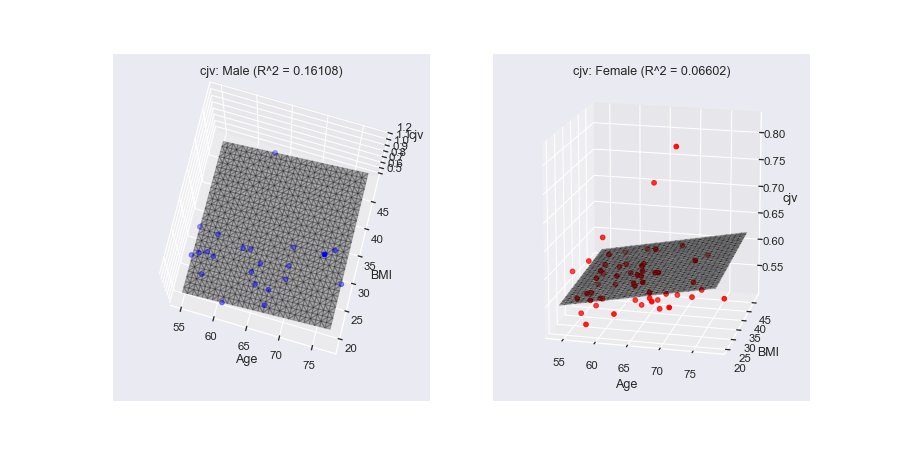

C:\Users\Nishant Bhamidipati\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Passing arguments to show(), other than passing 'block' by keyword, is deprecated 3.1, and support for it will be removed in 3.3.


Enter variable (enter 'end' to graph): end


In [5]:
#Make data tables
df_temp = df.copy(deep=True)
var = getVar()
while var != "end":
    for col in df_temp.columns.drop(['id0','id0.1','id0.2','id0.3','id0.4','id0.5','id0.6','id0.7','run_id','Age','Sex','datetime']):   
        #create temporary dataframes for regression equations 
        if var in col:
            df_temp_Age = df_temp[df_temp['Age'].notna()]
            df_temp_Sex = df_temp[df_temp['Sex'].notna()]

            df_temp_Male = df_temp_Sex.copy(deep=True)
            df_temp_Male.drop(df_temp_Male.loc[df_temp_Male['Sex']=='Female'].index, inplace=True)
            df_temp_Male = df_temp_Male[df_temp_Male[col].notna()]

            df_temp_Female = df_temp_Sex.copy(deep=True)
            df_temp_Female.drop(df_temp_Female.loc[df_temp_Female['Sex']=='Male'].index, inplace=True)
            df_temp_Female = df_temp_Female[df_temp_Female[col].notna()]

            df_temp_MaleMLR = df_temp_Male.copy(deep=True)
            df_temp_MaleMLR = df_temp_MaleMLR[df_temp_MaleMLR['Age'].notna()]
            df_temp_MaleMLR = df_temp_MaleMLR[df_temp_MaleMLR['BMI'].notna()]

            df_temp_FemaleMLR = df_temp_Female.copy(deep=True)
            df_temp_FemaleMLR = df_temp_FemaleMLR[df_temp_FemaleMLR['Age'].notna()]
            df_temp_FemaleMLR = df_temp_FemaleMLR[df_temp_FemaleMLR['BMI'].notna()]
            #Multiple Linear Regression, split by sex

            #Male
            mlr1 = LinearRegression()
            mlr1.fit(df_temp_MaleMLR[['Age', 'BMI']], df_temp_MaleMLR[col])
            intercept = mlr1.intercept_
            slope = mlr1.coef_
            r_value = mlr1.score(df_temp_MaleMLR[['Age', 'BMI']],df_temp_MaleMLR[col]) 

            #Female
            mlr2 = LinearRegression()
            mlr2.fit(df_temp_FemaleMLR[['Age', 'BMI']], df_temp_FemaleMLR[col])
            intercept2 = mlr2.intercept_
            slope2 = mlr2.coef_
            r_value2 = mlr2.score(df_temp_FemaleMLR[['Age', 'BMI']],df_temp_FemaleMLR[col])  

            if(r_value>.01 or r_value2>.01):
                create3DGraph(col, r_value, r_value2, mlr1, mlr2)

            var = getVar()